# Lab Three - Clustering


Team Members
* Chance Robinson
* Dan Crouthamel
* Shane Weinstock

# Business Understanding 1


_Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific dataset and the stakeholders needs?_

In [1]:
# Base Imports
import pandas as pd
import numpy as np 
import time
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns; sns.set()
%matplotlib inline

# Pre-Processing
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Metrics and Evaluation
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve

# Train/ Test Split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline

# Imbalanced Data
# from imblearn.over_sampling import SMOTE
# from imblearn.over_sampling import BorderlineSMOTE
# from imblearn.pipeline import make_pipeline, Pipeline

# Estimators
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier

# Hyper Parameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# T-Tests
# from mlxtend.evaluate import paired_ttest_5x2cv

# Machine Learning Visualizations
# from yellowbrick.classifier import ROCAUC
# from yellowbrick.classifier import PrecisionRecallCurve
# from yellowbrick.classifier import ClassificationReport


plt.style.use("ggplot")

# Data Understanding 1

_Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?_


## Load Data

In [2]:
df = pd.read_csv('../../../../../../data/cardio_train.csv', delimiter=';')
# set id as index
df.set_index("id", inplace=True)
# copy original data
df_clean = df.copy(deep=True)
# drop duplicates
df_clean.drop_duplicates(inplace=True)

## Apply Transformations

In [3]:
# %%time
# re-encode gender to male (1) and female (0)
df_clean['gender'] = np.where((df_clean.gender == 2), 1, 0)
# If > 200, replace with ap_hi median (120)
# If < 80 (median for ap_lo), replace with ap_hi median (120)
df_clean['ap_hi'] = np.where(df_clean['ap_hi'] > 200, 120, df_clean['ap_hi'])
df_clean['ap_hi'] = np.where(df_clean['ap_hi'] < 80, 120, df_clean['ap_hi'])
# If > 120 (median for hi), replace with ap_lo median (80)
# If < 0 replace with ap_lo median (80)
df_clean['ap_lo'] = np.where(df_clean['ap_lo'] > 120, 80, df_clean['ap_lo'])
df_clean['ap_lo'] = np.where(df_clean['ap_lo'] < 0, 80, df_clean['ap_lo'])


**Table 1: Cardiovascular Dataset - Attribute Descriptions**

| Column Description | Feature Type | Column Name | Data Type |
|:---|:---|:---|:---|
| **Age**                        | Objective | age | int (days) |
| **Height**                     | Objective | height | int (cm) |
| **Weight**                     | Objective | weight | float (kg) |
| **Gender**                     | Objective | gender | 0: female, 1: male |
| **Systolic blood pressure**    | Examination | ap_hi | int |
| **Diastolic blood pressure**   | Examination | ap_lo | int |
| **Cholesterol**                | Examination | cholesterol | 1: normal, 2: above normal, 3: well above normal |
| **Glucose**                    | Examination | gluc | 1: normal, 2: above normal, 3: well above normal |
| **Smoking**                    | Subjective  | smoke | binary |
| **Alcohol intake**             | Subjective | alco | binary |
| **Physical activity**          | Subjective | active | binary |
| **Has CVD?**                   | Target * | cardio | binary |

In [4]:
df_clean.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000
mean,19468.950126,0.349648,164.359152,74.208519,126.911398,81.215145,1.366997,1.226535,0.088159,0.053790,0.803718,0.499771
std,2467.374620,0.476862,8.211218,14.397211,16.839718,9.533994,0.680333,0.572353,0.283528,0.225604,0.397187,0.500004
min,10798.000000,0.000000,55.000000,10.000000,80.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17664.000000,0.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19703.000000,0.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21327.000000,1.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,1.000000,250.000000,200.000000,200.000000,120.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


# Data Understanding 2


_Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs._



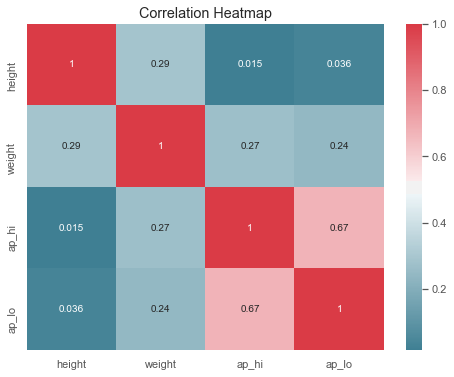

In [5]:
corr_features = ['height', 'weight', 'ap_hi', 'ap_lo',]

plt.figure(figsize=(8,6))

# Use an easier to see colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Mask
correlation = df_clean[corr_features].corr()
# correlation[np.abs(correlation)<.2] = 0

sns.heatmap(correlation, annot = True, cmap=cmap).set(title = 'Correlation Heatmap')
plt.show()

### Baseline Classification Performance

In [6]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

numeric_features = ['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc']
categorical_features = ['gender', 'smoke', 'alco', 'active']

# Impute Numeric Features with the mean value

# One Hot Encode Categorical Features

# Robust Scaler
from sklearn.preprocessing import RobustScaler
rs = RobustScaler()
df_clean[["age", "height", "weight", "ap_hi", "ap_lo"]] = rs.fit_transform(df_clean[["age", "height", "weight", "ap_hi", "ap_lo"]])


X_cols = ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']

y = df_clean['cardio']
X = df_clean[X_cols]
cv = StratifiedKFold(n_splits=10)

clf_logreg = LogisticRegression(random_state=1, penalty='l2', C=.01)


roc = cross_val_score(clf_logreg, X, y=y, cv=cv, scoring='roc_auc')

print ("Average ROC (AUC) = ", roc.mean()*100, "+-", roc.std()*100)



Average ROC (AUC) =  79.1507617264313 +- 0.5833047553922216


# Modeling and Evaluation 1


_Train and adjust parameters_

In [7]:
from kneed import KneeLocator

# kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
# n_clusters = kl.elbow
# n_clusters

In [8]:
# plt.figure()
# # plt.subplot(1,2,1)
# X2=X2.values
# plt.scatter(X2[:, 0], X2[:, 1]+np.random.random(X2[:, 1].shape)/2, c=new_feature, cmap=plt.cm.rainbow, s=20, linewidths=0)
# plt.xlabel('ap_hi (normalized)'), plt.ylabel('ap_lo (normalized)')
# plt.grid()


## Spectral Clustering

In [9]:
%%time

# an example using SpectralClustering, which assumes that the graphi
from sklearn.cluster import SpectralClustering

X_cols = ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']

y = df_clean['cardio']
X = df_clean[X_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=1)

X2 = X_train[['ap_hi','ap_lo']]

y = y_train
X = X_train[['age', 'gender', 'height', 'weight', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']]

nclust = 3

# If a string, this may be one of 
#  ‘nearest_neighbors’, ‘precomputed’, ‘rbf’ 
#  or one of the kernels supported by sklearn.metrics.pairwise_kernels
spc = SpectralClustering(n_clusters=nclust, affinity='nearest_neighbors', n_jobs=-1, random_state=1, assign_labels="kmeans")
labels = spc.fit_predict(X2)

X = np.column_stack((X, pd.get_dummies(labels)))

roc = cross_val_score(clf_logreg, X, y=y, cv=cv, scoring='roc_auc')

print ("Average ROC (AUC) = ", roc.mean()*100, "+-", roc.std()*100)

# plt.scatter(X2[:, 0], X2[:, 1], c=labels,
#                     cmap=plt.cm.rainbow, s=5, linewidths=0)

# plt.show()

Average ROC (AUC) =  70.33518306981759 +- 1.860514655267977
Wall time: 1min 33s


# Modeling and Evaluation 2


_Evaluate and Compare_


# Modeling and Evaluation 3


_Visualize Results_

# Modeling and Evaluation 4

_Summarize the Ramifications_



# Deployment 


_Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling? How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?_

# Exceptional Work


_You have free reign to provide additional analyses or combine analyses._


In [10]:
X_cols = ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']

y = df_clean['cardio']

X = df_clean[X_cols]

clf_logreg = LogisticRegression(random_state=1)

pipe_logreg = Pipeline([['clf', clf_logreg]])

model_params = {
    # "logisticregression": {
    #     "model": pipe_logreg,
    #     "params": {
    #         "clf__C": [.01, .1, 1, 5, 10, 25, 50],
    #         "clf__penalty": ["l1", "l2"]
    #     }
    # }
}

scores = []

for model_name, mp in model_params.items():
    start = time.time()
    # clf = GridSearchCV(estimator = mp["model"], param_grid=mp["params"], cv=10, scoring="roc_auc", n_jobs=-1)
    clf = RandomizedSearchCV(estimator = mp["model"], param_distributions=mp["params"], cv=10, scoring="roc_auc", n_jobs=-1)
    clf.fit(X, y)
    elapsed_time = (time.time() - start)

    scores.append({"Model": model_name,
    "Best ROC AUC": clf.best_score_, # Mean cross-validated score of the best_estimator
    "Best Params": clf.best_params_,
    "results": clf.cv_results_,
    "Cross Validation Time": elapsed_time,
    "Best Estimator": clf.best_estimator_
    })

In [11]:
print('10 Fold Cross Validation Scores (CVD):')

for model in scores:
    print()
    for key, value in model.items():
        if key == 'Best Estimator':
            print("Prediction Accuracy",': ',value.score(X, y))
        elif key == 'results':
            print('Mean Fit Time: ', value['mean_fit_time'].mean())
            print('Mean Score Time: ', value['mean_score_time'].mean())
        else:
            print(key,': ',value)

10 Fold Cross Validation Scores (CVD):
